<a href="https://colab.research.google.com/github/Jairosandoval/datasets_data_v2/blob/main/Proyecto_EVS_Coder_DS2pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importaciòn de librerìas

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import urllib.request
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV


# Importaciòn de DBS

**Importaciòn de dataset de operaciones diarias**:

Esto me permite ver los recorridos de los vehìculos por cliente, placa modelo y ver el consumo de energìa que estan teniendo.

In [ ]:
#Leo la direcciòn de URL
Operaciones= 'https://raw.githubusercontent.com/Jairosandoval/datasets_data_v2/refs/heads/main/operaciones_diarias.csv'

df_operations = pd.read_csv(Operaciones, sep=';') # Agrego la separaciòn de coma para que se pueda leer
print(df_operations.shape)
df_operations.head()

(10086, 9)


,dia,Operador,Modelo,Placa,Odometro Final,Odometro Inicial,Distancia Diaria,energy,kWh/km
0,27/06/2023,GRUPO MODELO,BYD T018 SWB,RE7705A,6010,6010.0,0.0,0,NaN
1,18/08/2023,GRUPO MODELO,VW eDelivery,RN4490A,11232,11232.0,0.0,0,NaN
2,20/02/2024,DEMOS,JAC E Sunray,DEMO-DHL,5456,5456.0,0.0,0,NaN
3,15/04/2024,99 MINUTOS,Dayun E3,A404AG,13796,13796.0,0.0,NaN,NaN
4,18/04/2024,DEMOS,Yutong ZK6180BEVG,DEMO-18M-L4,61396,61396.0,0.0,NaN,NaN


**Importaciòn de dataset de alertas**:

Esto me permite ver las alertas de los vehìculos por cliente, placa modelo y ver que alertas son las màs comunes

In [ ]:
#Leo la direcciòn de URL
alerts= 'https://raw.githubusercontent.com/Jairosandoval/datasets_data_v2/refs/heads/main/alertas_vf.csv'

df_alerts = pd.read_csv(alerts, sep=';') # Agrego la separaciòn de coma para que se pueda leer
print(df_alerts.shape)
df_alerts.head()

(6485, 4)


,utz_begin,plate,ntf,val
0,15/07/2024,LSF1L230XPD200768,over speed,"88,75"
1,07/06/2024,24J527,over speed,101
2,01/06/2024,16N961,hard break,118
3,15/06/2024,49J620,over temp,45
4,31/08/2024,LSF1L2305PD200774,over speed,8.971.875


# Etapa de exploraciòn y previo ETL

In [ ]:
# Contabilizo total de eventos
event_counts = df_alerts.groupby('ntf')['ntf'].count()

print(event_counts)


ntf
crit soc       167
hard accel     143
hard break     145
low soc        568
over speed    2763
over temp     2699
Name: ntf, dtype: int64


In [ ]:
#Renombro las columnas del df_alerts para que esten iguales
df_alerts = df_alerts.rename(columns={"plate": "placa", "utz_begin":"dia"})
print (df_alerts.shape)
df_alerts.head()

(6485, 4)


,dia,placa,ntf,val
0,15/07/2024,LSF1L230XPD200768,over speed,"88,75"
1,07/06/2024,24J527,over speed,101
2,01/06/2024,16N961,hard break,118
3,15/06/2024,49J620,over temp,45
4,31/08/2024,LSF1L2305PD200774,over speed,8.971.875


Me aseguro que ambas tablas estèn manejando mismo tipo de formato en la fecha

In [ ]:
# Formateo ambos tipos de datos a mismo tipo.
df_operations['dia'] = pd.to_datetime(df_operations['dia'])
df_alerts['dia'] = pd.to_datetime(df_alerts['dia'])

print(df_operations['dia'].dtype)
print(df_alerts['dia'].dtype)


datetime64[ns]
datetime64[ns]


<ipython-input-6-b29af1bcaad2>:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_operations['dia'] = pd.to_datetime(df_operations['dia'])
<ipython-input-6-b29af1bcaad2>:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_alerts['dia'] = pd.to_datetime(df_alerts['dia'])


Ahora, quiero combinar las tablas pero antes de eso quiero hacer una limpieza, de valores nulos por 0 etc

In [ ]:
print("Valores nulos en df_operations:")
print(df_operations.isnull().sum())

print("\nValores nulos en df_alerts:")
print(df_alerts.isnull().sum())


Valores nulos en df_operations:
dia                    0
Operador               0
Modelo                 0
Placa                  0
Odometro Final         0
Odometro Inicial     105
Distancia Diaria     105
energy               954
kWh/km              2155
dtype: int64

Valores nulos en df_alerts:
dia      0
placa    0
ntf      0
val      0
dtype: int64


En alerts no tengo ningùn valor nulo pero en df_operations si.

Paso a eliminar los mismos que no hayan presentado distancia diaria(quiere decir que no se movieron)

In [ ]:
#Elimino registros nulos de distancia diaria = nulo
df_operations = df_operations.dropna(subset=['Distancia Diaria'])
#compruebo
print("Valores nulos en df_operations:")
print(df_operations.isnull().sum())


Valores nulos en df_operations:
dia                    0
Operador               0
Modelo                 0
Placa                  0
Odometro Final         0
Odometro Inicial       0
Distancia Diaria       0
energy               849
kWh/km              2050
dtype: int64


In [ ]:
#convierto los datos a tipo correcto
df_operations['Distancia Diaria'] = df_operations['Distancia Diaria'].astype(int)
df_operations['energy']= df_operations['Distancia Diaria'].astype(float)
# Replace commas with periods for decimal separator before converting to float
df_operations['kWh/km'] = df_operations['kWh/km'].str.replace(',', '.').astype(float)

print(df_operations['Distancia Diaria'].dtype)
print(df_operations['energy'].dtype)
print(df_operations['kWh/km'].dtype)

int64
float64
float64


In [ ]:
# Calcula el promedio de 'kWh/km' **antes** de usarlo en fillna
mean_kWh_km = df_operations['kWh/km'].mean()

# Ahora sustituyo los valores nulos de kwh/km por el promedio
df_operations['kWh/km'] = df_operations['kWh/km'].fillna(mean_kWh_km)

# Verifico de nuevo si quedan valores nulos en 'kWh/km'
print(df_operations['kWh/km'].isnull().sum())

0


In [ ]:
#Ahora compruebo que no hay valores nulos
print("Valores nulos en df_operations:")
print(df_operations.isnull().sum())


Valores nulos en df_operations:
dia                 0
Operador            0
Modelo              0
Placa               0
Odometro Final      0
Odometro Inicial    0
Distancia Diaria    0
energy              0
kWh/km              0
dtype: int64


In [ ]:
df_operations.head()

,dia,Operador,Modelo,Placa,Odometro Final,Odometro Inicial,Distancia Diaria,energy,kWh/km
0,2023-06-27,GRUPO MODELO,BYD T018 SWB,RE7705A,6010,6010.0,0,0.0,0.670279
1,2023-08-18,GRUPO MODELO,VW eDelivery,RN4490A,11232,11232.0,0,0.0,0.670279
2,2024-02-20,DEMOS,JAC E Sunray,DEMO-DHL,5456,5456.0,0,0.0,0.670279
3,2024-04-15,99 MINUTOS,Dayun E3,A404AG,13796,13796.0,0,0.0,0.670279
4,2024-04-18,DEMOS,Yutong ZK6180BEVG,DEMO-18M-L4,61396,61396.0,0,0.0,0.670279


Exploro la tabla de alertas, contabilizando el total de notificaciones sin importar el tipo

In [ ]:
# Cuento la cantidad de eventos por 'placa', 'dia' y 'ntf' en df_alerts
df_alerts_count = df_alerts.groupby(['dia', 'placa', 'ntf']).size().reset_index(name='total_alertas')
#Ahora, sumo el total por placa y dìa, tambièn sin importar el tipo de notifiaciòn
df_alerts_count_total = df_alerts.groupby(['dia', 'placa']).size().reset_index(name='total_eventos')

print(df_alerts_count)

            dia    placa         ntf  total_alertas
0    2024-06-01  003A009  hard accel              1
1    2024-06-01  003A009  hard break              1
2    2024-06-01  003A010  hard accel              1
3    2024-06-01  003A010  hard break              1
4    2024-06-01  003A011  hard accel              1
...         ...      ...         ...            ...
2703 2024-09-01   32J973     low soc              1
2704 2024-09-01   33J082     low soc              2
2705 2024-09-01   58J360  over speed              2
2706 2024-09-01   58J363  over speed              1
2707 2024-09-01   80F209  over speed              1

[2708 rows x 4 columns]


In [ ]:
import pandas as pd

# Renombro las placas en df_operations
df_operations = df_operations.rename(columns={'Placa': 'placa'})

# Merge df_alerts con df_alerts_contabilizando el total_alertas
df_alerts_with_count = pd.merge(df_alerts, df_alerts_count[['dia', 'placa', 'total_alertas']], on=['dia', 'placa'], how='left')

# Merge df_operations with the new DataFrame containing total_alertas
macro_df = pd.merge(df_operations, df_alerts_with_count[['dia', 'placa', 'ntf', 'val', 'total_alertas']], on=['dia', 'placa'], how='left')

print(macro_df.head())

         dia      Operador             Modelo        placa  Odometro Final  \
0 2023-06-27  GRUPO MODELO       BYD T018 SWB      RE7705A            6010   
1 2023-08-18  GRUPO MODELO       VW eDelivery      RN4490A           11232   
2 2024-02-20         DEMOS       JAC E Sunray     DEMO-DHL            5456   
3 2024-04-15    99 MINUTOS           Dayun E3       A404AG           13796   
4 2024-04-18         DEMOS  Yutong ZK6180BEVG  DEMO-18M-L4           61396   

   Odometro Inicial  Distancia Diaria  energy    kWh/km  ntf  val  \
0            6010.0                 0     0.0  0.670279  NaN  NaN   
1           11232.0                 0     0.0  0.670279  NaN  NaN   
2            5456.0                 0     0.0  0.670279  NaN  NaN   
3           13796.0                 0     0.0  0.670279  NaN  NaN   
4           61396.0                 0     0.0  0.670279  NaN  NaN   

   total_alertas  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  


**Creaciòn de tercera tabla llamada df_marco**

La idea es tener una tabla donde me de un resumen de todas las alertas presentadas por operador, placa, modelo distancia energia consumida, el promedio de energia/Km, y el total de eventos por placa.

Para ello, voy a combinar la tabla de operations y la tabla de alerts para crear una sola

#   Inicio de respuestas a consultas exploratorias planteadas


In [ ]:


# Selecciono las columnas del df_operations que voy a usar
operations_selected = df_operations[['dia', 'Operador', 'Modelo', 'placa', 'Odometro Final', 'Odometro Inicial', 'Distancia Diaria', 'energy', 'kWh/km']]

# Selecciono las columnas de df_alerts que voy a usar
alerts_selected = df_alerts[['dia', 'placa', 'ntf', 'val']]

# Merge de los dfs
macro_df = pd.merge(operations_selected, alerts_selected, on=['dia', 'placa'], how='left')

print(macro_df.head())

         dia      Operador             Modelo        placa  Odometro Final  \
0 2023-06-27  GRUPO MODELO       BYD T018 SWB      RE7705A            6010   
1 2023-08-18  GRUPO MODELO       VW eDelivery      RN4490A           11232   
2 2024-02-20         DEMOS       JAC E Sunray     DEMO-DHL            5456   
3 2024-04-15    99 MINUTOS           Dayun E3       A404AG           13796   
4 2024-04-18         DEMOS  Yutong ZK6180BEVG  DEMO-18M-L4           61396   

   Odometro Inicial  Distancia Diaria  energy    kWh/km  ntf  val  
0            6010.0                 0     0.0  0.670279  NaN  NaN  
1           11232.0                 0     0.0  0.670279  NaN  NaN  
2            5456.0                 0     0.0  0.670279  NaN  NaN  
3           13796.0                 0     0.0  0.670279  NaN  NaN  
4           61396.0                 0     0.0  0.670279  NaN  NaN  


# ETL adicional para eliminar outliers


**Realizo un ejercicio adicional para ver outliers en cuanto a distancia diaria por operador o cliente**

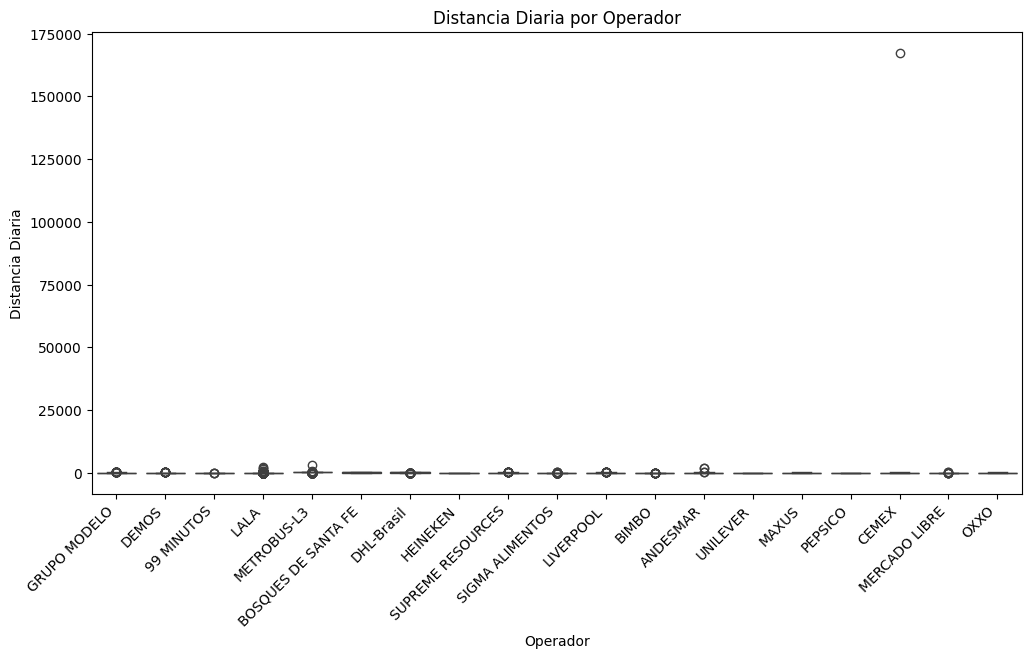

In [ ]:


# Creao un boxplot de distancia diaria vs operator
plt.figure(figsize=(12, 6))
sns.boxplot(x='Operador', y='Distancia Diaria', data=macro_df)
plt.title('Distancia Diaria por Operador')
plt.xlabel('Operador')
plt.ylabel('Distancia Diaria')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:


# Eliminar valores mayores a 500 en la columna 'Distancia Diaria'
macro_df= macro_df[macro_df['Distancia Diaria'] <= 400]

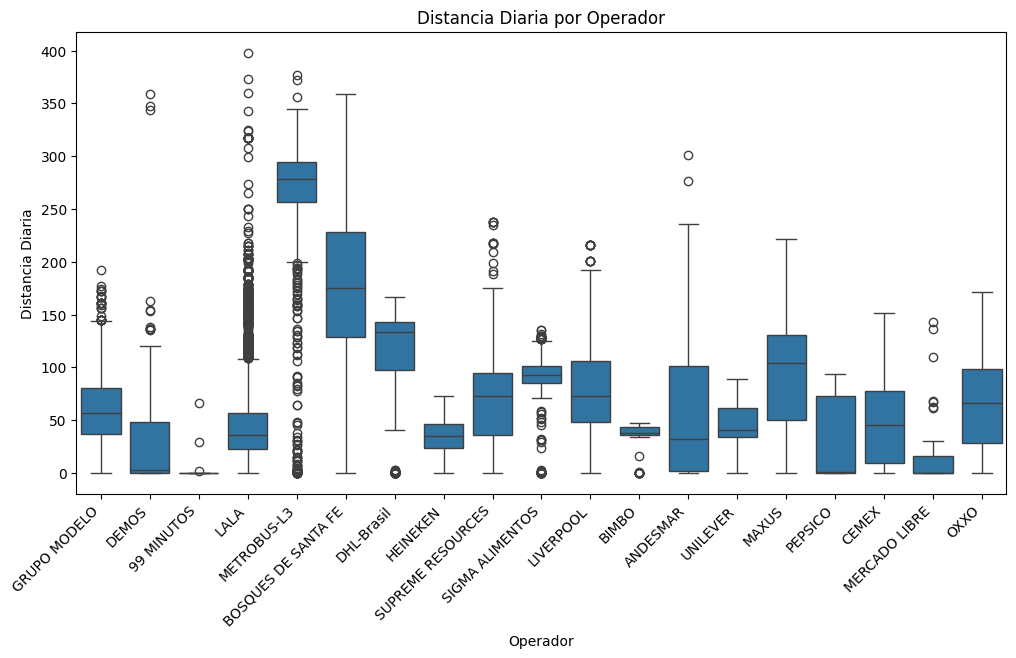

In [ ]:
# Creo un boxplot de distancia diaria vs operator
plt.figure(figsize=(12, 6))
sns.boxplot(x='Operador', y='Distancia Diaria', data=macro_df)
plt.title('Distancia Diaria por Operador')
plt.xlabel('Operador')
plt.ylabel('Distancia Diaria')
plt.xticks(rotation=45, ha='right')
plt.show()

Ahora, veo que Metrobus tiene casi todos outliers, por ende proceso a eliminarlo. Tambièn veo de eliminar distancias mayores a 120kms de Lala

In [ ]:
# Ahora paso a eliminar al operador metrobus del df macro_df

# Eliminar las filas donde 'Operador' es igual a 'Metrobus'
macro_df = macro_df[macro_df['Operador'] != 'METROBUS-L3']

*Luego, paso a eliminar outliers de los demàs clientes mas no clientes**

In [ ]:
# Quiero eliminar las distancias mayores inusuales que veo de cada cliente

# Eliminar distancias mayores a 120 de LALA
macro_df = macro_df[~((macro_df['Operador'] == 'LALA') & (macro_df['Distancia Diaria'] > 120))]

# Eliminar distancias mayores a 200 de DEMO
macro_df = macro_df[~((macro_df['Operador'] == 'DEMOS') & (macro_df['Distancia Diaria'] > 200))]
# Eliminar distancias mayores a 170 de SUPREME RESOURCES
macro_df = macro_df[~((macro_df['Operador'] == 'SUPREME RESOURCES') & (macro_df['Distancia Diaria'] > 170))]

# Eliminar distancias mayores a 200 DE ANDESMAR
macro_df = macro_df[~((macro_df['Operador'] == 'ANDESMAR') & (macro_df['Distancia Diaria'] > 200))]

# Eliminar distancias mayores a 150 DE GRUPO MODELO
macro_df = macro_df[~((macro_df['Operador'] == 'GRUPO MODELO') & (macro_df['Distancia Diaria'] > 150))]





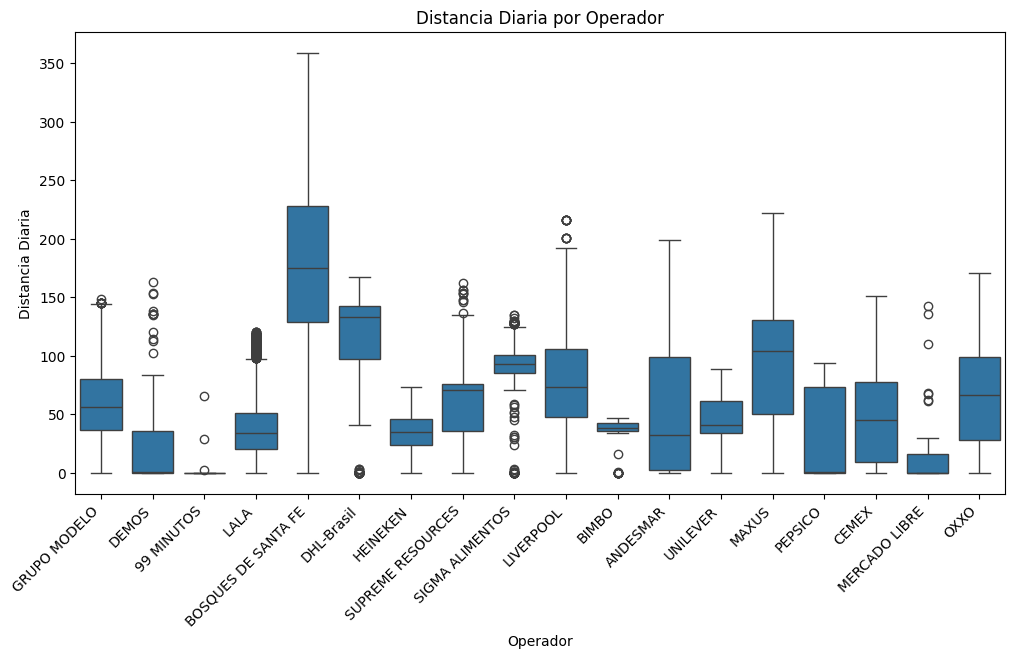

In [ ]:
# Ahora compruebo que estè ok
plt.figure(figsize=(12, 6))
sns.boxplot(x='Operador', y='Distancia Diaria', data=macro_df)
plt.title('Distancia Diaria por Operador')
plt.xlabel('Operador')
plt.ylabel('Distancia Diaria')
plt.xticks(rotation=45, ha='right')
plt.show()

# Prueba de modelo supervisado MODELO SUPERVISADO


**REGRESION LINEAL**

DISTANCIA VS ENERGY

Paso 1 a separar datos de train vs test

In [ ]:
# Definir variables X e y
X = macro_df[['Distancia Diaria']]
y = macro_df['energy']

# Separar en conjuntos de entrenamiento y prueba (80% entrenamiento y 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**Paso 2 entreno el modelo de regresiòn lineal**

In [ ]:
# Crear y entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)


**Paso 4 Evaluo el modelo**


**Para eso uso el modelo de coeficiente de determinacion R2**: Esto para ver el porcentaje de la varianza de Energy explica la distancia diaria.

**Ademàs el ERROR CUADRATICO MEDIO (MSE)** para medir la precisiòn de las predicciones

In [ ]:
#Calculo el coeficiente de determinacion R2 y el MSE

r2= r2_score(y_test,y_pred)
mse= mean_squared_error(y_test,y_pred)

print(f"Coeficiente de Determinación R²: {r2:.2f}")
print(f"Error Cuadrático Medio (MSE): {mse:.2f}")



Coeficiente de Determinación R²: 1.00
Error Cuadrático Medio (MSE): 0.00


**Paso 4 visualizar la relacion y linea de regresion**

Para ver de una mejor manera la relacion entre distancia diaria y energy. Grafico los puntos y la linea de regresion

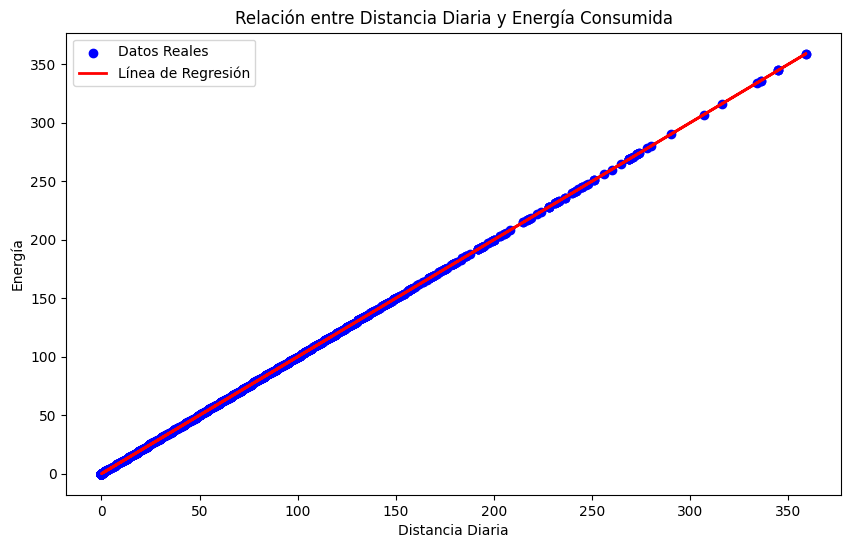

In [ ]:
#grafico ahora la dispersion de los datos y la linea de la regresion
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Datos Reales')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Línea de Regresión')
plt.xlabel("Distancia Diaria")
plt.ylabel("Energía")
plt.title("Relación entre Distancia Diaria y Energía Consumida")
plt.legend()
plt.show()


Parece que existe un overfiting o esta muy relacionads las variables. Vamos a hacer una validaciòn cruzada.

**Paso adicional:** Validaciòn cruzada

In [ ]:
from sklearn.model_selection import cross_val_score

# Realizar validación cruzada con 5 particiones (5-fold cross-validation)
cross_val_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print("Coeficientes de Determinación R² en cada partición:", cross_val_scores)
print("Promedio de R²:", cross_val_scores.mean())


Coeficientes de Determinación R² en cada partición: [1. 1. 1. 1. 1.]
Promedio de R²: 1.0


**Dado que existe una estrecha relaciòn entre distancia y energia usada, lo que es lògico, vamos a usar las variables de consumos de kWh/km vs ntf de manejo y ver como se porta**

**PASO 1** Anàlisis exploratorio

Voy a usar la distribuciòn de kWh/Km y ver como se comporta en funciòn de ntf, que es el scoring de manejo.

**PROBLEMA A RESOLVER**, como ntf es de tipo texto y val es decimal, me va a traer muchos porblemas al querer comparar valor entero vs ellos.

Entonces,voy a identificar los tipos de eventos existentes en ntf y crear un diccionario para mapear los tipos de alertas, asi creo los id_ntf

**Paso anterior**, voy a ir eliminando las filas con valores NAN o Nulos en Val y kWh y sustituir los valores nulos con la mediana de cada una.



In [ ]:
# Eliminar filas con valores NaN en las columnas 'val' y 'kWh/Km'
macro_df = macro_df.dropna(subset=['val', 'kWh/km'])
macro_df = macro_df.dropna(subset=['val', 'val'])


In [ ]:
#Chequeo el tamaño del DF ya con la depuraciòn

print("Tamaño del dataframe después de eliminar NaN:", macro_df.shape)


Tamaño del dataframe después de eliminar NaN: (5124, 11)


In [ ]:
# Imputar valores nulos en 'val' y 'kWh/km' con la mediana de cada columna

# Convert 'val' column en numerico, handling errors
# If 'val' is es numerico, this step should be skipped.
# If you need to replace '.' and ',', you should do this AFTER conversion to string
macro_df['val'] = pd.to_numeric(macro_df['val'], errors='coerce')

#Calculate median and impute missing values
median_val = macro_df['val'].median()
macro_df['val'].fillna(median_val, inplace=True)

# Instead of using string methods, directly convert to numeric if needed
# and then impute. This assumes 'kWh/km' might already be partially numeric
macro_df['kWh/km'] = pd.to_numeric(macro_df['kWh/km'], errors='coerce')
median_kwh_km = macro_df['kWh/km'].median()
macro_df['kWh/km'].fillna(median_kwh_km, inplace=True)

# Verificar si hay valores nulos después de la imputación
print(macro_df[['val', 'kWh/km']].isnull().sum())

val       0
kWh/km    0
dtype: int64


<ipython-input-29-b3ea1c30f762>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  macro_df['val'].fillna(median_val, inplace=True)
<ipython-input-29-b3ea1c30f762>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

In [ ]:
# Revisar las primeras filas del dataframe para ver que este ok de buena calidad el DF.
print(macro_df.head())
print("Cantidad de valores NaN en cada columna:")
print(macro_df.isna().sum())


          dia             Operador   Modelo   placa  Odometro Final  \
8  2024-06-01  BOSQUES DE SANTA FE  JAC EJ7  42F134          123627   
9  2024-06-01  BOSQUES DE SANTA FE  JAC EJ7  42F134          123627   
10 2024-06-01  BOSQUES DE SANTA FE  JAC EJ7  42F134          123627   
11 2024-06-01  BOSQUES DE SANTA FE  JAC EJ7  42F134          123627   
12 2024-06-01  BOSQUES DE SANTA FE  JAC EJ7  42F134          123627   

    Odometro Inicial  Distancia Diaria  energy  kWh/km         ntf     val  
8           123376.0               251   251.0    0.18  hard break  1206.0  
9           123376.0               251   251.0    0.18   over temp    38.0  
10          123376.0               251   251.0    0.18   over temp    38.0  
11          123376.0               251   251.0    0.18   over temp    36.0  
12          123376.0               251   251.0    0.18  hard accel   991.0  
Cantidad de valores NaN en cada columna:
dia                 0
Operador            0
Modelo              0
plac

In [ ]:


# If 'kWh/km' is not already numeric, convert it first
# Check if the column is already numeric
if not pd.api.types.is_numeric_dtype(macro_df['kWh/km']):
    # If not numeric, convert to string, then to numeric.
    macro_df['kWh/km'] = macro_df['kWh/km'].astype(str).str.replace('.', '', regex=False)
    macro_df['kWh/km'] = pd.to_numeric(macro_df['kWh/km'], errors='coerce')

#Similar procedure for 'val' column
# Check if the column is already numeric
if not pd.api.types.is_numeric_dtype(macro_df['val']):
    # If not numeric, convert to string, then to numeric.
    macro_df['val'] = macro_df['val'].astype(str).str.replace('.', '', regex=False)
    macro_df['val'] = pd.to_numeric(macro_df['val'], errors='coerce')

# Now you can impute missing values with the median
macro_df['val'] = macro_df['val'].fillna(macro_df['val'].median())
macro_df['kWh/km'] = macro_df['kWh/km'].fillna(macro_df['kWh/km'].median())

# Verify the size of the dataframe after imputation
print("Tamaño del dataframe después de imputar NaN:", macro_df.shape)

Tamaño del dataframe después de imputar NaN: (5124, 11)


# 2nda prueba de modelo SUPERVISADO (kWh/Km vs id_ntf) con ajustes adicionales

In [ ]:
# Identifico los tipos únicos de alertas en 'ntf'
unique_ntf = macro_df['ntf'].unique()
print("Tipos únicos de alertas/notificaciones:", unique_ntf)

Tipos únicos de alertas/notificaciones: ['hard break' 'over temp' 'hard accel' 'over speed' 'low soc' 'crit soc']


In [ ]:
# Normalizo los valores en 'ntf' (eliminar espacios y convertir a minúsculas)
macro_df['ntf'] = macro_df['ntf'].str.strip().str.lower()

In [ ]:
#Visualizo las distintas alertas
print(macro_df['ntf'].unique())


['hard break' 'over temp' 'hard accel' 'over speed' 'low soc' 'crit soc']


In [ ]:


# Creo la columna id_ntf
if 'id_ntf' not in macro_df.columns:
    macro_df['id_ntf'], _ = pd.factorize(macro_df['ntf'])

# Ahora corro el script para ver de que no haya ningun error y que me muestre los tipos de ntf e id_ntf
unique_ntf_mapping = macro_df[['ntf', 'id_ntf']].drop_duplicates().sort_values(by='id_ntf')
print(unique_ntf_mapping)

            ntf  id_ntf
8    hard break       0
9     over temp       1
12   hard accel       2
23   over speed       3
28      low soc       4
493    crit soc       5


In [ ]:
#Ahora enumero mejor desde 1 y no desde 0


if 'id_ntf' in macro_df.columns:
  macro_df['id_ntf'] = macro_df['id_ntf'] + 1

# Now, 'id_ntf' will start from 1.
# You can verify this by printing the unique values of 'id_ntf':

print(macro_df['id_ntf'].unique())

# You can also print the updated unique_ntf_mapping:
unique_ntf_mapping = macro_df[['ntf', 'id_ntf']].drop_duplicates().sort_values(by='id_ntf')
unique_ntf_mapping

[1 2 3 4 5 6]


,ntf,id_ntf
8,hard break,1
9,over temp,2
12,hard accel,3
23,over speed,4
28,low soc,5
493,crit soc,6


In [ ]:
#verifico los tipos de datos a evaluar

print(macro_df['id_ntf'].dtype)
print(macro_df['kWh/km'].dtype)

int64
float64


**nueva eliminaciòn de valores nulos en los id_ntf y verificacion tipo de dato**

In [ ]:
# Convierto id_ntf a entero
macro_df['id_ntf'] = macro_df['id_ntf'].astype(int)

# Verificar el tipo de datos
print(macro_df.dtypes)


dia                 datetime64[ns]
Operador                    object
Modelo                      object
placa                       object
Odometro Final               int64
Odometro Inicial           float64
Distancia Diaria             int64
energy                     float64
kWh/km                     float64
ntf                         object
val                        float64
id_ntf                       int64
dtype: object


**COMIENZO DE CORRIDA DE MODELO DE REGRESION LINEAL KWH/KM VS ID_NTF**

**Paso 1 a separar datos de train vs test**

In [ ]:
#Defino X e Y para la regresiòn
X_ntf = macro_df[['id_ntf']]
y_kwh_per_km= macro_df['kWh/km']

# Divido los datos en entrenamiento y prueba
X_train_ntf, X_test_ntf, y_train_kwh_per_km, y_test_kwh_per_km = train_test_split(X_ntf, y_kwh_per_km, test_size=0.2, random_state=42)

**Paso 2 entreno el modelo de regresiòn lineal**

In [ ]:
model_ntf = LinearRegression()
model_ntf.fit(X_train_ntf, y_train_kwh_per_km)



LinearRegression()

**PASO 3 EVALUO EL MODELO**

In [ ]:
# Evaluar el modelo
y_pred_ntf = model_ntf.predict(X_test_ntf)
r2_ntf = r2_score(y_test_kwh_per_km, y_pred_ntf)
mse_ntf = mean_squared_error(y_test_kwh_per_km, y_pred_ntf)

In [ ]:
print(f"Coeficiente de Determinación R² para id_ntf y kWh/km: {r2_ntf:.2f}")
print(f"Error Cuadrático Medio (MSE) para id_ntf y kWh/km: {mse_ntf:.2f}")

Coeficiente de Determinación R² para id_ntf y kWh/km: 0.30
Error Cuadrático Medio (MSE) para id_ntf y kWh/km: 0.13


**RESULTADO** Esto me indica que teniendo el R2 de 0.30 lo convierte en una
relaciòn dèbil o casi nula. Ahora, voy a ver si hay valores muy extremos o outliers en kWh/Km y que estè afectando los resultados.

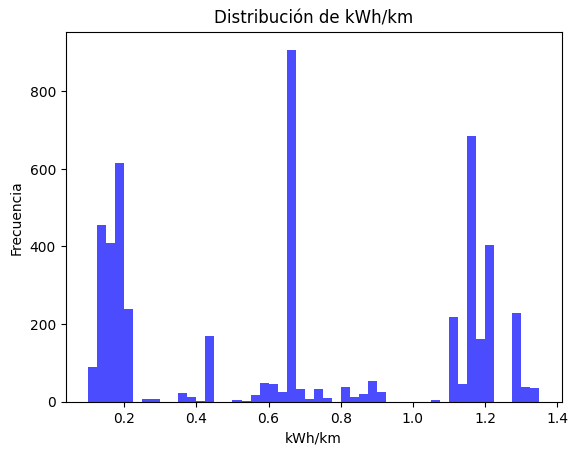

In [ ]:
# Histograma para observar la distribución de kWh/km
plt.hist(macro_df['kWh/km'], bins=50, color='blue', alpha=0.7)
plt.xlabel('kWh/km')
plt.ylabel('Frecuencia')
plt.title('Distribución de kWh/km')
plt.show()


**RESULTADO** Esto me dice que la distribuciòn de kwh/KM tiene valores absurdos o muy altos, lo cual ayuda a explicar el gran error cuadràtico medio MSE.


# 3 Prueba de comparar variables de energy vs id_ntf mediante K MEANS


**3 PROUESTA** Vamos a comparar las variables de energy vs id_ntf. Deberìa tener mucho màs dependencia del nùmero de alertas, en especial aquellas relacionadas con el comportamiento infeficiente, como exceso de velocidad.

**Paso 1, preparaciòn de los datos**
Selecciono las variables con las que voy a trabajar y normalizar las diferencias entre disctancia diaria y energy

In [ ]:
#Selecciono las variables

x_cluster =macro_df[['Distancia Diaria', 'id_ntf', 'energy']]

#Escalo los datos
# selecciono la libreria SKLEARN
from sklearn.preprocessing import StandardScaler
#Ahora clusterizo
scaler=StandardScaler()
x_cluster_scaled= scaler.fit_transform(x_cluster)

**PASO 2 determino el nùmero òptimo de clusteres**
(Uso el mètodo del codo para identificar el nùmero adecuado de clusters)


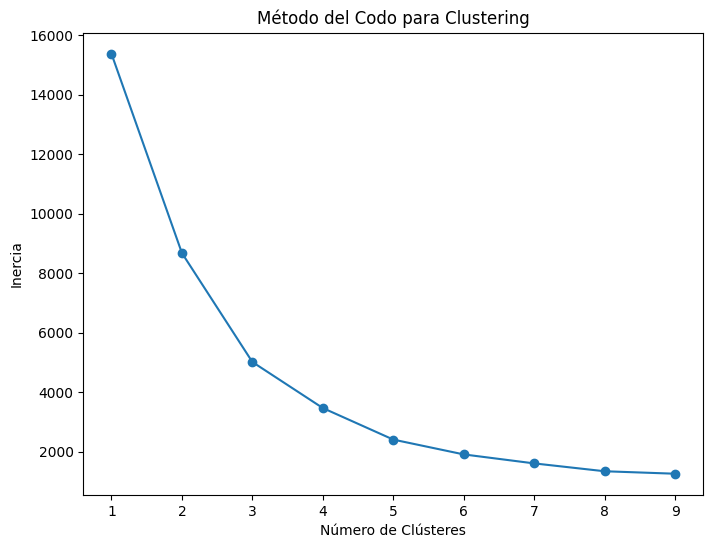

In [ ]:
# Importo las librerias necesarias
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans # Import KMeans from sklearn.cluster

# Aplico el método del codo
inertia = []
for k in range(1, 10):  # Pruebo entre 1 y 10 clústeres
    kmeans = KMeans(n_clusters=k, random_state=42) # Ahora defino el KMEANS
    kmeans.fit(x_cluster_scaled)
    inertia.append(kmeans.inertia_)

# Grafico el codo
plt.figure(figsize=(8, 6))
plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Número de Clústeres')
plt.ylabel('Inercia')
plt.title('Método del Codo para Clustering')
plt.show()

**PASO 3: Aplico 3 clusters para probar,  aplico el modelo**

**MODELO 1: K-MEANS**

In [ ]:
#Aplico K means

kmeans = KMeans(n_clusters=3, random_state=42) #aca voy viendo si ajusto o no dependiendo como me sale
macro_df['cluster'] = kmeans.fit_predict(x_cluster_scaled)

#Veo resultado
# Changed 'Cluster' to 'cluster' to match the column name
print(macro_df[['Distancia Diaria', 'id_ntf', 'energy', 'cluster']].head())

    Distancia Diaria  id_ntf  energy  cluster
8                251       1   251.0        2
9                251       2   251.0        2
10               251       2   251.0        2
11               251       2   251.0        2
12               251       3   251.0        2


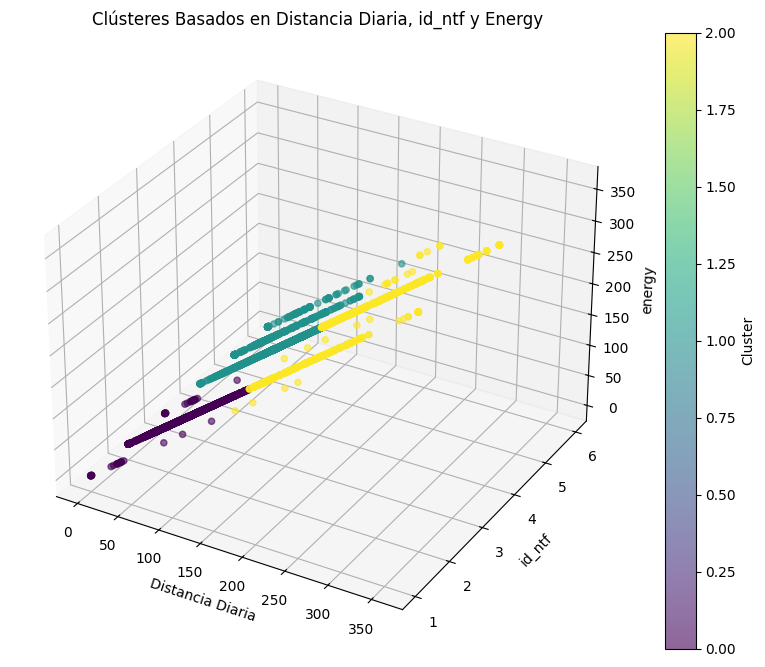

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Crear figura 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Graficar los clústeres
scatter = ax.scatter(
    macro_df['Distancia Diaria'],
    macro_df['id_ntf'],
    macro_df['energy'],
    c=macro_df['cluster'],
    cmap='viridis',
    alpha=0.6
)

# Etiquetas
ax.set_xlabel('Distancia Diaria')
ax.set_ylabel('id_ntf')
ax.set_zlabel('energy')
plt.title('Clústeres Basados en Distancia Diaria, id_ntf y Energy')
plt.colorbar(scatter, label='Cluster')
plt.show()

**Comentarios previos**

En principio, vemos que como se separaron en 3, los colores me indican que parece estar bien segmentado.

La distancia y energy tienen una clara relaciòn como ya se comprobò, a medida aumenta distancia aumenta energy.

La variable id_ntf parece jugar mas bien un papel secundario. Esto sugiere que ciertos tipos de notificaciones estan asociados con patrones especificos de consumo y distancia.

Ahora lo importante e interpretaciòn clara:

-Cluster 0 (morado)= Vehìculos que recorren menos distancia y por ende menor consumo de energìa.

-Cluster 1 ( verde)= Son distancias y energia promedio o moderada.

-Cluster 2 ( amarillo)= Vehiculos con mayores distancias y consumos energeticos.


Ahora, en cuanto a las alertas/notificaciones que incurren, podemos deducir que:



*   El segmento Morado incurre màs en aceleraciones bruscas, frenadas bruscas y sobre temperaturas: Esto nos abre una hipòtesis: Que los EVs con mayores eventos de aceleraciones o frenadas bruscas tienden mayormente a tener recalentanmientos o sobre temperaturas, a escepcion de algunos casos. Esto es algo que hace falta determinar.

*   El segmento verde y amarillo tiende mayormente a sufrir sobe descargas, lo que nos ayuda a saber que a pesar de tener mayor desplazamiento de distancia, las sobre velocidades influyen en sobre descargas, quiere decir que se descarga màs ràpido de los esperado por sus conductores/operadores.








# Desafìo con 3 modelos de clasificaciòn


**En este caso, voy a usar varios modelos para determinar los operadores por tipo de notificacion o id_ntf, de manera de que pueda ver las tendencias de comportamiento, como la propensión a ciertos eventos (sobre velocidad, sobre temperatura, etc.). Esto podría ser muy útil para identificar patrones y anticipar acciones correctivas o preventivas.

Por ende la variables serìan asì:

 **DEPENDIENTE** seria Energy
**INDEPENDIENTE** seria i_ntf




In [ ]:
#PASO 1: Selecciono las variables independientes X & Y.

X = macro_df[['energy']]  # Variable independiente
y = macro_df['id_ntf']  # Variable dependiente (tipo de notificación)

In [ ]:
#PASO 2: Dividio el conjunto de datos entre train vs test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Import las clases necesarias del mòdulo sklearn
from sklearn.linear_model import LogisticRegression

#PASO 3 creo el modelo de clasificaciòn logistica
model = LogisticRegression(max_iter=1000)

In [ ]:
#PASO 4 Entreno el modelo de clasificaciòn logistica
model = LogisticRegression(max_iter=1000)

In [ ]:
# Importo las clases necesarias del mòdulo sklearn
from sklearn.linear_model import LogisticRegression

# PASO 3 creo el modelo de clasificaciòn logistica
model = LogisticRegression(max_iter=1000)

# PASO 4 Entreno el modelo de clasificaciòn logistica

model.fit(X_train, y_train)

# PASO 5 predigo los valores en los datos de la prueba
y_pred = model.predict(X_test)

In [ ]:
# Importo librerias necesarias por si acaso
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report # Importo accuracy_score, confusion_matrix y classification_report

# ... (your existing code for data loading, splitting, and model training) ...

#PASO 6 Evaluo el modelo

# Paso 6: Evaluar el modelo
accuracy = accuracy_score(y_test, y_pred)  # Precisión
conf_matrix = confusion_matrix(y_test, y_pred)  # Matriz de confusión
class_report = classification_report(y_test, y_pred)  # Reporte de clasificación

print(f"Precisión del modelo: {accuracy}")
print(f"Matriz de Confusión:\n{conf_matrix}")
print(f"Reporte de Clasificación:\n{class_report}")

Precisión del modelo: 0.6068292682926829
Matriz de Confusión:
[[  0   7   0   0   0   0]
 [  0 441   0  69   0   0]
 [  0   6   0   1   0   0]
 [  0 201   0 181   0   0]
 [  0  90   0   6   0   0]
 [  0  21   0   2   0   0]]
Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         7
           2       0.58      0.86      0.69       510
           3       0.00      0.00      0.00         7
           4       0.70      0.47      0.56       382
           5       0.00      0.00      0.00        96
           6       0.00      0.00      0.00        23

    accuracy                           0.61      1025
   macro avg       0.21      0.22      0.21      1025
weighted avg       0.55      0.61      0.55      1025



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Para la clase id_ntf = 2 (que probablemente sea "over speed"), el modelo tiene una precisión de 58%, un recall de 86% y un f1-score de 69%. Esto significa que el modelo es bastante bueno para identificar la clase 2, aunque hay mucho espacio para mejorar la precisión.



Las clases id_ntf = 1, id_ntf = 3, id_ntf = 5, y id_ntf = 6 tienen un rendimiento muy bajo, con precisión y recall de 0%. Esto indica que el modelo no está prediciendo bien estas clases, lo que puede deberse a que tienen menos casos en el conjunto de datos o porque el modelo no ha aprendido correctamente a clasificarlas.

**PREVIA CONCLUSIÒN** Esto me dice que a pesar de tener una precisiòn general de 61% no es muy eficiente para predecir los id_ntf 1,3,5 y 6.

**SOLUCIÒN O PROX PASOS** Voy a aplicar tècnicas de sobre muestreo SMOTE o submuestreo para ver de balancearlo.

In [ ]:
#INSTALO LIBRERIA IMBALANCED LEARN

!pip install imbalanced-learn

# Definir las variables independientes y la dependiente
from imblearn.over_sampling import SMOTE # Importo SMOTE de imblearn.over_sampling

X = macro_df[['energy', 'Distancia Diaria']]  # Variables independientes
y = macro_df['id_ntf'] #Variable dependiente

# Divido train vs test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicar SMOTE al entrenamiento.
smote = SMOTE(sampling_strategy='auto', random_state=42) # Ahora SMOTE está definido
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Verifico el balance de las clases después de aplicar SMOTE
print(f'Clases antes de SMOTE: {y_train.value_counts()}')
print(f'Clases después de SMOTE: {y_train_res.value_counts()}')

Clases antes de SMOTE: id_ntf
2    2114
4    1482
5     355
6     107
1      21
3      20
Name: count, dtype: int64
Clases después de SMOTE: id_ntf
2    2114
4    2114
5    2114
6    2114
1    2114
3    2114
Name: count, dtype: int64


In [ ]:
# Entreno el modelo
from sklearn.ensemble import RandomForestClassifier # Importo RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_res, y_train_res)

# Realizo ahora las predicciones
y_pred = rf_model.predict(X_test)

# Evaluo el modelo
print(f'Precisión del modelo: {rf_model.score(X_test, y_test)}')
print('Matriz de Confusión:')
print(confusion_matrix(y_test, y_pred))
print('Reporte de Clasificación:')
print(classification_report(y_test, y_pred))

Precisión del modelo: 0.5551219512195122
Matriz de Confusión:
[[  0   0   1   0   5   1]
 [ 10 240   0 137  79  44]
 [  1   0   0   1   2   3]
 [  4  68   0 286  15   9]
 [  2  22   5  12  37  18]
 [  0   8   1   3   5   6]]
Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         7
           2       0.71      0.47      0.57       510
           3       0.00      0.00      0.00         7
           4       0.65      0.75      0.70       382
           5       0.26      0.39      0.31        96
           6       0.07      0.26      0.12        23

    accuracy                           0.56      1025
   macro avg       0.28      0.31      0.28      1025
weighted avg       0.62      0.56      0.57      1025



**RESULTADO**
A pesar de que la precisiòn del modelo dio 55% (menos que el anterior) ha mejorado algunas clases, pero sigue sin ser suficiente. Parece que haca falta màs data.

# Pre entrega final corriendo 3 modelos de clasificacion

Para esto, voy a estar utilizando las variables de energia y distancia diaria como variables independientes y la de id_ntf como variable dependiente.

In [ ]:
#PASO 1 divido las variables pendientes e independientes
X = macro_df[['energy', 'Distancia Diaria']]  # Variables independientes
y = macro_df['id_ntf']  # Variable dependiente

In [ ]:
#PASO 2 divido el conjunto de datos en entrenamiento y prueba
from sklearn.model_selection import train_test_split # import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

1 **ARBOL DE DECISION**

In [ ]:

# 1. Modelo de clasificación - Árbol de Decisión
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

**2 MODELO DE RANDOM FOREST**

In [ ]:
#En este caso avanzo aplicando el modelo (paso 3), quiere decir me salto paso 1 y 2 que son seleccionar variables dependientes e independientes y el train vs test
# 2. Modelo de clasificación - Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

**3 MODELO DE k-NEARST o mas cercano**

In [ ]:
# 3. Modelo de clasificación - K-Nearest Neighbors (KNN)
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

KNeighborsClassifier()

**EVALUACION DE LOS MODELOS Y GRÀFICADO**

Precisión del Árbol de Decisión: 0.6341463414634146
Matriz de Confusión para Árbol de Decisión:
 [[  0   5   0   0   2   0]
 [  0 381   0 117  12   0]
 [  0   6   0   1   0   0]
 [  0 119   0 260   3   0]
 [  0  74   0  13   9   0]
 [  0  15   0   5   3   0]]
Reporte de Clasificación para Árbol de Decisión:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         7
           2       0.64      0.75      0.69       510
           3       0.00      0.00      0.00         7
           4       0.66      0.68      0.67       382
           5       0.31      0.09      0.14        96
           6       0.00      0.00      0.00        23

    accuracy                           0.63      1025
   macro avg       0.27      0.25      0.25      1025
weighted avg       0.59      0.63      0.60      1025



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


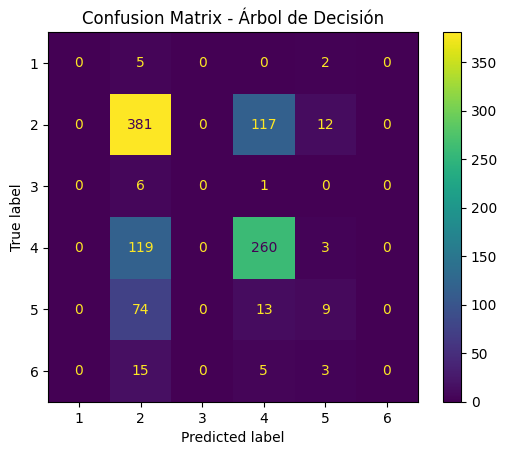

Precisión del Random Forest: 0.6370731707317073
Matriz de Confusión para Random Forest:
 [[  0   5   0   0   2   0]
 [  0 372   0 123  14   1]
 [  0   6   0   1   0   0]
 [  0 111   0 268   3   0]
 [  0  70   0  13  13   0]
 [  0  15   0   5   3   0]]
Reporte de Clasificación para Random Forest:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         7
           2       0.64      0.73      0.68       510
           3       0.00      0.00      0.00         7
           4       0.65      0.70      0.68       382
           5       0.37      0.14      0.20        96
           6       0.00      0.00      0.00        23

    accuracy                           0.64      1025
   macro avg       0.28      0.26      0.26      1025
weighted avg       0.60      0.64      0.61      1025



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


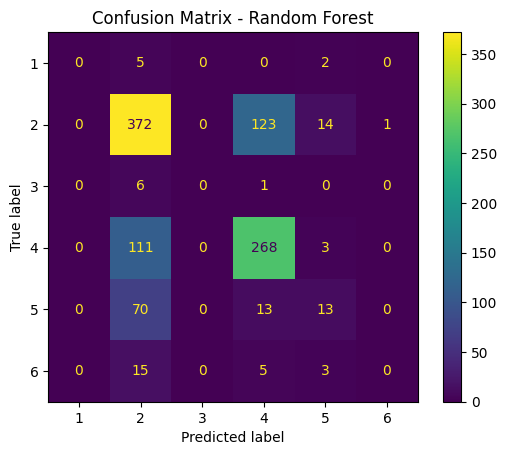

Precisión del KNN: 0.6165853658536585
Matriz de Confusión para KNN:
 [[  0   5   0   0   2   0]
 [  0 382   0 104  24   0]
 [  0   4   0   0   3   0]
 [  0 148   0 226   8   0]
 [  0  63   0   9  24   0]
 [  0  11   0   4   8   0]]
Reporte de Clasificación para KNN:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         7
           2       0.62      0.75      0.68       510
           3       0.00      0.00      0.00         7
           4       0.66      0.59      0.62       382
           5       0.35      0.25      0.29        96
           6       0.00      0.00      0.00        23

    accuracy                           0.62      1025
   macro avg       0.27      0.27      0.27      1025
weighted avg       0.59      0.62      0.60      1025



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


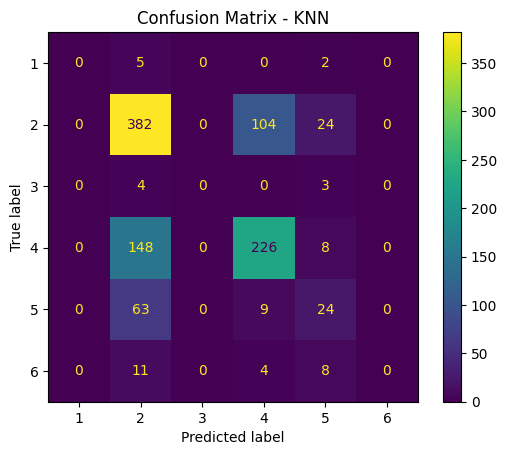

In [ ]:
# Evaluo los modelos
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay # importo las funcione necesarias para revisar


models = [tree_clf, rf_clf, knn_clf]
model_names = ['Árbol de Decisión', 'Random Forest', 'KNN'] #Aca selecciono los modelos

for model, name in zip(models, model_names):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Precisión del {name}: {accuracy}')
    print(f'Matriz de Confusión para {name}:\n', confusion_matrix(y_test, y_pred))
    print(f'Reporte de Clasificación para {name}:\n', classification_report(y_test, y_pred))

    # Graficar el reporte
    # Uso ConfusionMatrixDisplay en lugar de plot_confusion_matrix
    disp = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    disp.ax_.set_title(f'Confusion Matrix - {name}')
    plt.show()

**Precisión general (accuracy)**


*   Árbol de Decisión: 63.4%
*   Random Forest: 63.7%
*   KNN 61,6%

Me sigue mostrando valores flojos en los 1 3, 5 y 6. Esto me dice que tiene problemas problemas para predecirlos.

**AJUSTE DE HIPER PARAMETROS**

**EN CASO DE ARBOL DE DECISIÒN**:  Vamos a usar max_depth, que Controla la profundidad máxima del árbol.

Para eso uso SMOTE y normalizo las caracteristicas.

In [ ]:
# 1. Balancear las clases con SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# 2. Normalizar las características
scaler = StandardScaler()
X_res_scaled = scaler.fit_transform(X_res)

# 3. Ajustar el modelo de Árbol de Decisión con GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7, 10, None],  # Pruebo varios valores para la profundidad
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Instanciamos el clasificador
dt_classifier = DecisionTreeClassifier(random_state=42)

# Realizo la búsqueda de los mejores parámetros
grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_res_scaled, y_res)

# Mejor parámetro encontrado
print(f"Mejores parámetros: {grid_search.best_params_}")

# Evaluo el rendimiento del mejor modelo
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_res_scaled)

# Evaluamos el rendimiento
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print(f"Precisión del Árbol de Decisión: {accuracy_score(y_res, y_pred)}")
print(f"Matriz de Confusión para Árbol de Decisión:\n{confusion_matrix(y_res, y_pred)}")
print(f"Reporte de Clasificación para Árbol de Decisión:\n{classification_report(y_res, y_pred)}")


Fitting 5 folds for each of 45 candidates, totalling 225 fits
Mejores parámetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Precisión del Árbol de Decisión: 0.6655868902439024
Matriz de Confusión para Árbol de Decisión:
[[1998   50   97    9   93  377]
 [   2 1377    0  644  356  245]
 [ 512   49 1596    7   84  376]
 [  26  375   12 2009  133   69]
 [ 170  293   38  141 1428  554]
 [ 254   22   82   26  169 2071]]
Reporte de Clasificación para Árbol de Decisión:
              precision    recall  f1-score   support

           1       0.67      0.76      0.72      2624
           2       0.64      0.52      0.57      2624
           3       0.87      0.61      0.72      2624
           4       0.71      0.77      0.74      2624
           5       0.63      0.54      0.58      2624
           6       0.56      0.79      0.66      2624

    accuracy                           0.67     15744
   macro avg       0.68      0.67      0.66     15744
weighted avg       

**CONCLUSION MODELO 1 ARBOL DE DECISIÒN**:
Mejorò la precisiòn de 63,4% a 66,5%.

Ahora, yendo a detalles, puedo decir que:

**id_ntf 3(HARD ACCEL)** tiene una alta aceptaciòn, ya que tiene una precision de 87% y recall de 61%. Sin embargo no es perfecto, por lo que puedo ver que hay varios que no esta reconociendo bien.


**id_ntf 4(OVER SPEED)**  Tiene una precision de 71% y recall de 77% ( mas alto),es bueno reconociendo esta variable pero con pocos errores, reconoce la mayoria.

**id_ntf 1(HARD BREAK)** Precision relativamente bien 67% y recall un poco mejor de 77%. Aunque hay algo de error, por ejemlo hay algunos que son del 1 confundidos con la clase 6.

Es decir, puedo tomar de este modelo los de clase 1, 3 y 4, pero mas los del 4.

**EN CASO DE RANDOM FOREST**:  Vamos a usar:


*   max_depth: que Controla la profundidad máxima del árbol

*   n_estimators:va a definir cuàntos àrtboles tendrà, a mayor nùmero, mas robusto.

*min_samples_split: Me va a ayudar a definir el mìnimo de muestras requeriddas para dividir un nodo.




In [ ]:

# Defino el modelo
rf = RandomForestClassifier(random_state=42)

# Defino el espacio de búsqueda
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}

# Configuro la búsqueda
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')

# Realizo la búsqueda
grid_search.fit(X_train, y_train)

# Muestro los mejores parámetros y la mejor precisión
print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor precisión: {grid_search.best_score_}")


Mejores parámetros: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}
Mejor precisión: 0.6506453438160755


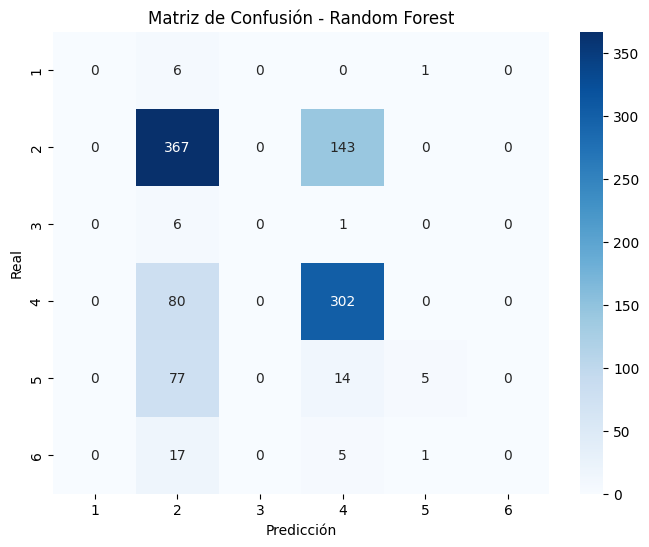

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         7
           2       0.66      0.72      0.69       510
           3       0.00      0.00      0.00         7
           4       0.65      0.79      0.71       382
           5       0.71      0.05      0.10        96
           6       0.00      0.00      0.00        23

    accuracy                           0.66      1025
   macro avg       0.34      0.26      0.25      1025
weighted avg       0.64      0.66      0.62      1025



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# 1. Ahora obtengo el mejor modelo
best_rf = grid_search.best_estimator_

# 2. Realizo las predicciones sobre el conjunto de prueba
y_pred = best_rf.predict(X_test)

# 3. Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# 4. Visualizo la matriz de confusión con  la libreria de seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4, 5, 6], yticklabels=[1, 2, 3, 4, 5, 6])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Random Forest')
plt.show()

# 5. Genero el reporte de clasificación
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))


**CONCLUSION MODELO 2 ARBOL DE RANDOM FOREST**:
Mejorò la precisiòn de 61,6% a 65%.

Ahora, yendo a detalles, puedo decir que:

Las id_ntf 2 (over temp) y id_ntf 4 (over speed) reflejan el mejor desempeño en recall, aunque en precision aun tiene margen para mejorar.

Las 1,3 y 6 no hace predicciones correctas.

La id_ntf 5 tiene un problema importante, ya que tiene una alta precision pero un recall muy MUY bajo, lo qu creo que me indica que el modelo pocas veces identifica correctamente.

En general, aunque en promedio es de 65%, esta sesgado por clases que no estan bien clasificadas.

**EN CASO DE CONFUSIÒN MATRIX**:  Vamos a usar:

*SMORTE: tècnica de que genera nuevas instancias sinteticas de clases minoritarias, que me ayuda a equilibrar el conjunto de datos.

*Reescalado de pesos:Usando class_weight

In [ ]:
from imblearn.over_sampling import SMOTE

# Aplicar SMOTE para balancear las clases
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


In [ ]:
rf = RandomForestClassifier(class_weight='balanced', random_state=42)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                                   param_distributions=param_dist,
                                   n_iter=10,
                                   cv=5,
                                   scoring='accuracy',
                                   random_state=42)

random_search.fit(X_train, y_train)
print(f"Mejores parámetros encontrados: {random_search.best_params_}")


Mejores parámetros encontrados: {'n_estimators': 200, 'min_samples_split': 20, 'min_samples_leaf': 4, 'max_depth': 5}


In [ ]:
from sklearn.metrics import roc_auc_score

# Get the best RandomForestClassifier from random_search
random_forest = random_search.best_estimator_

# Calcular AUC-ROC
# Remove [:, 1] to get probabilities for all classes
y_pred_prob = random_forest.predict_proba(X_test)
# Add the 'multi_class' parameter for multi-class classification
auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr')  # or multi_class='ovo'
print(f"AUC-ROC: {auc}")

AUC-ROC: 0.8061014406505099


**ROC**: Esto me indica que el modelo tiene buena capacidad para distinguir entre las clases positivas y negativas del conjunto de datos.

En pocas palabras, esta mètrica es una mètrica de rendimiento para problemas de clasificaciòn que mide la capacidad de cualquier modelo para distinguir entre diferentes clases. Etnonces, la tasa de verdaderos positivos (o sensibilidad) frente a falsos positivos (1-especificidad) para varios umbrales de clasificaciòn.

Segun, la vaina es asi:

*   0,5 : Un modelo con un AUC de 0,5 no es mejor que una suposición aleatoria. No tiene poder discriminatorio.

*   0,5 - 0,7 : Esto indica un rendimiento del modelo entre deficiente y aceptable. El modelo tiene cierta capacidad para distinguir entre clases, pero no es muy confiable.


*   0,7 - 0,8 : Esto representa un buen rendimiento del modelo. El modelo tiene una capacidad razonable para distinguir entre clases.

*  0,8 - 0,9 : Esto indica un rendimiento muy bueno del modelo. El modelo tiene una gran capacidad para distinguir entre clases.


*   0,9 - 1,0 : Esto representa un rendimiento excelente del modelo. El modelo tiene una capacidad excepcional para distinguir entre clases.


**EN RESUMEN**: En términos prácticos, esto significa que si selecciona aleatoriamente una instancia positiva y una negativa, hay una probabilidad del 80,6 % de que el modelo clasifique correctamente la instancia positiva por encima de la negativa. AUNQUE es ùtl no es el ùnico factor a tener en cuenta para el modelo.


Es por eso que voy ahora como el resto con precision, recall y F1

Precisión del KNN: 0.6341463414634146
Matriz de Confusión para KNN:
 [[  0   5   0   0   2   0]
 [  0 381   0 117  12   0]
 [  0   6   0   1   0   0]
 [  0 119   0 260   3   0]
 [  0  74   0  13   9   0]
 [  0  15   0   5   3   0]]
Reporte de Clasificación para KNN:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         7
           2       0.64      0.75      0.69       510
           3       0.00      0.00      0.00         7
           4       0.66      0.68      0.67       382
           5       0.31      0.09      0.14        96
           6       0.00      0.00      0.00        23

    accuracy                           0.63      1025
   macro avg       0.27      0.25      0.25      1025
weighted avg       0.59      0.63      0.60      1025



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


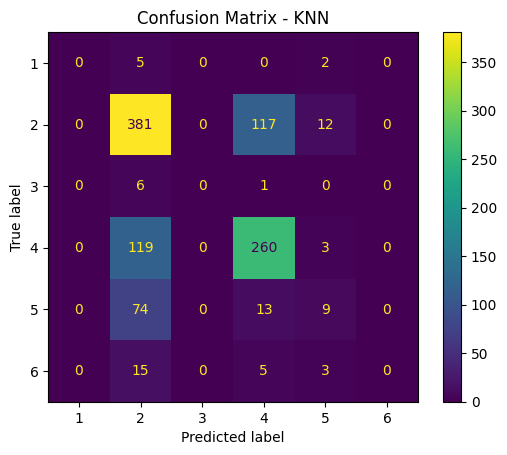

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


models = [tree_clf, rf_clf, knn_clf]
model_names = [ 'KNN']

for model, name in zip(models, model_names):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Precisión del {name}: {accuracy}')
    print(f'Matriz de Confusión para {name}:\n', confusion_matrix(y_test, y_pred))
    print(f'Reporte de Clasificación para {name}:\n', classification_report(y_test, y_pred))



    # Grafico el reporte
    disp = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    disp.ax_.set_title(f'Confusion Matrix - {name}')
    plt.show()

**CONCLUSION MODELO 3 CONFUSION MATRIX--KNN**:
Mejorò la precisiòn de 61% a 63%.


ENTONCES:

ID_NTF 2 y 4 tuvieron una precision parecida pero en recall el id_nitf un poco mas alto 2 que el 4 ( 75% ante 68%).

El resto de id_ntf sigue deficiente o MUY malo.

El desempeño es muy desigual.




#CONCLUSIONES PE ENTREGA FINAL CORRIENDO 3 MODELOS DE CLASIFICACION

En tèrminos generales, los id_ ntf 5 y 6 en los 3 modelos me da una confianza y precision muy baja para poder confiarme de ello.

En cuanto a precisiòn de modelos en general, va en la siguiente escala:



*  Arbol de decision: 66,5%
*  Random Forest: 65%
*  KNN: 63,4%





Ahora, analizando un poco, usaria los siguientes modelos para predecir segùn cada id_ntf:



*   ID_NTF 1 (Hard break) Usaria arbol de decision, tiene 67% y recall un poco mejor de 77%. Aunque hay algo de error, por ejemlo hay algunos que son del 1 confundidos con la clase 6.

*  ID_NTF 2 (over temp) Usaria el modelo de KNN, con 75% de recall y 64% de precision.



*   ID_NTF 3 (hard accel) Usaria el modelo de arbol de decision, ya que tiene el valor màs alto de 87% de precision y recall de 61%


*   ID_NTF 4 (over speed) usaria el modelo de arbol de decision, ya que tiene un 71% de precicion y recall de 77%.












**APLICACION DEL PCA**

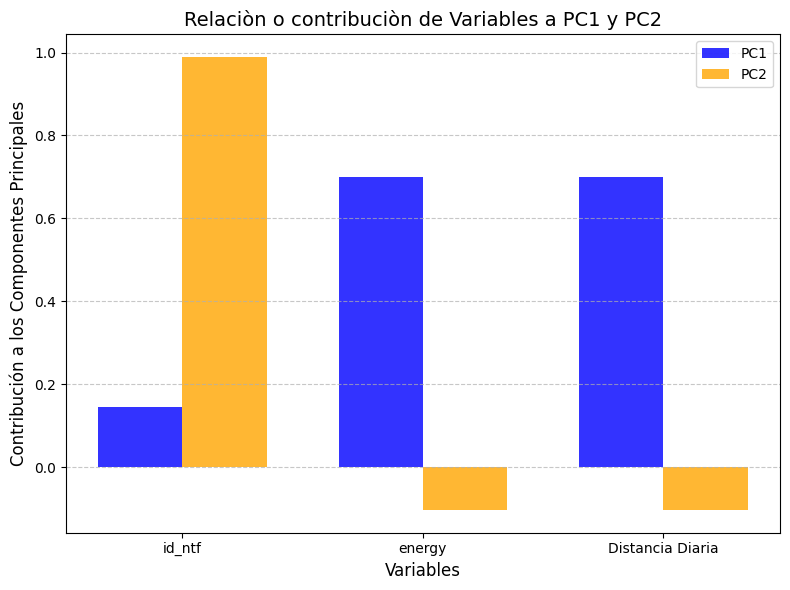

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de las contribuciones de las variables a los componentes principales
variables = ['id_ntf', 'energy', 'Distancia Diaria']
pc1 = [0.1458407, 0.69954646, 0.69954646]
pc2 = [0.98930809, -0.10312494, -0.10312494]

# Crear la gráfica
fig, ax = plt.subplots(figsize=(8, 6))

# Graficar las contribuciones como barras apiladas
bar_width = 0.35
x = np.arange(len(variables))

ax.bar(x - bar_width / 2, pc1, bar_width, label='PC1', alpha=0.8, color='blue')
ax.bar(x + bar_width / 2, pc2, bar_width, label='PC2', alpha=0.8, color='orange')

# Etiquetas y diseño
ax.set_xlabel('Variables', fontsize=12)
ax.set_ylabel('Contribución a los Componentes Principales', fontsize=12)
ax.set_title('Relaciòn o contribuciòn de Variables a PC1 y PC2', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(variables, fontsize=10)
ax.legend(fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [ ]:
print("Componentes principales:\n", pca.components_)


NameError: name 'pca' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA # Import PCA

# Datos de las contribuciones de las variables a los componentes principales
variables = ['id_ntf', 'energy', 'Distancia Diaria']
# Assuming you have data in a variable called 'data'
# Replace 'data' with your actual data variable name
# If you don't have 'data' defined, please provide it
# Example: data = macro_df[['id_ntf', 'energy', 'Distancia Diaria']]
# If 'macro_df' is not defined, please provide it or its equivalent.

# Create a PCA object and fit it to your data
pca = PCA(n_components=2)  # Specify the desired number of components
pca.fit(macro_df[['id_ntf', 'energy', 'Distancia Diaria']]) # Assuming 'macro_df' is your DataFrame

# Calculate the contributions of the variables to PC1 and PC2
pc1 = pca.components_[0]
pc2 = pca.components_[1]

# ... (rest of your plotting code remains the same) ...

# Now you can print the principal components
print("Componentes principales:\n", pca.components_)

Componentes principales:
 [[ 1.38260204e-03  7.07106105e-01  7.07106105e-01]
 [ 9.99999044e-01 -9.77647281e-04 -9.77647281e-04]]


# BONUS--Aplicaciòn de modelo XGBoost

**SELECCIONO LAS VARIABLES**

In [ ]:
#Selecciono las mismas

X = macro_df[['energy', 'Distancia Diaria']]
y = macro_df['id_ntf']

**DIVIDO ENTRE TEST VS TRAIN**

In [ ]:

# Test vs train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**ENTRENO EL MODELO XGBOOS**

Para esto uso el clasificador XGBCLASSIFIER (para clasificacion) o XGBREGRESSOR (para regresion).

In [ ]:
!pip install xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Assuming X and y are already defined

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instead of subtracting 1, use LabelEncoder to ensure classes start from 0
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)


# Create and train the XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {accuracy:.2f}')


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:07:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.65      0.73      0.69       510
           2       0.00      0.00      0.00         7
           3       0.66      0.73      0.69       382
           4       0.32      0.09      0.15        96
           5       0.00      0.00      0.00        23

    accuracy                           0.64      1025
   macro avg       0.27      0.26      0.25      1025
weighted avg       0.60      0.64      0.61      1025

Model Accuracy: 0.64


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


# MLOS (Bajada de STREAMLIT)

**Què es Streamlit?**

*   Propòsito principal: Construcción de dashboards e interfaces web.


*   Gestión de Modelos: No tiene gestión de modelos directamente.

*   Visualización: Visualizaciones personalizables e interactivas.

*   Colaboración: Ideal para compartir dashboards interactivos.

*   Implementación: Para desplegar aplicaciones web.



**¿Cuándo usar Streamlit?**
Si necesitas crear una aplicación web para interactuar con tu modelo.
Ideal para mostrar predicciones, gráficos y métricas de forma dinámica.
Si tu profesor o equipo prefiere ver resultados en un formato más visual y no técnico.
Ventaja: Es perfecto para construir interfaces simples y compartir tus resultados.







**PASO 1**:Instalar Streamlit

In [ ]:
#Bajo Streamlit
!pip install streamlit

**PASO 2:**  (creo la carpeta de achivos vacios) =Estructura

In [ ]:
import os

# Crear la carpeta principal
os.makedirs("ml_project/data", exist_ok=True)

# Crear archivos vacíos
open("ml_project/app.py", "w").close()
open("ml_project/modelo_xgb.pkl", "w").close()
open("ml_project/data/train_data.csv", "w").close()
open("ml_project/data/test_data.csv", "w").close()

print("Estructura creada! vamo!")


Estructura creada! vamo!


#CAMBIO LA RUTA A DRIVE PARA TENERLA SIEMPRE AHI, pero para eso primero muevo la carpeta usando la API de Drive

In [ ]:
#CAMBIO LA RUTA A DRIVE PARA TENERLA SIEMPRE AHI, pero para eso primero muevo la carpeta usando la API de Drive

!pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib


**Autentico la cuenta de Google Drive**

Explicación del código
Autenticación: auth.authenticate_user() solicita permisos para trabajar con Google Drive.
Servicio de Google Drive: Crea un objeto drive_service para interactuar con la API.
Subir archivos a la carpeta destino: La función upload_folder_to_drive recorre la carpeta ml_project en /content y sube cada archivo al ID 1CZqrwUhXug7FJIsVpfwisyYn9MJ9TggU.

In [ ]:
from google.colab import auth
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload

# Autenticación de la cuenta
auth.authenticate_user()

# Creo servicio de Google Drive
drive_service = build('drive', 'v3')


**Muevo la carpeta a la ubicacion destino**
Para eso, uso el ID de la carpeta destino de ml_project

In [ ]:
# ID de la carpeta destino
destination_folder_id = "1CZqrwUhXug7FJIsVpfwisyYn9MJ9TggU"

# Busco la carpeta ml_project creada en Colab anteriormente en paso 2
import os
from googleapiclient.errors import HttpError

def upload_folder_to_drive(folder_path, parent_folder_id):
    for root, dirs, files in os.walk(folder_path):
        for file_name in files:
            file_path = os.path.join(root, file_name)
            file_metadata = {
                'name': file_name,
                'parents': [parent_folder_id]
            }
            media = MediaFileUpload(file_path, resumable=True)
            try:
                drive_service.files().create(body=file_metadata, media_body=media, fields='id').execute()
                print(f"Subido: {file_name}")
            except HttpError as error:
                print(f"Error al subir {file_name}: {error}")

# Subir la carpeta ml_project
upload_folder_to_drive('/content/ml_project', destination_folder_id)


Subido: modelo_xgb.pkl
Subido: app.py
Subido: train_data.csv
Subido: test_data.csv


Se crearon los archivos, y ahora voy a descargar los archivos a mi escritorio para mejor trabajar

In [ ]:
#compruebo corrida de Streamlit
!streamlit run app.py

Usage: streamlit run [OPTIONS] TARGET [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: app.py


Comprimo la carpeta en un archivo ZIP:

